<a href="https://colab.research.google.com/github/strangehiccups/ECE1513_Source/blob/main/Evaluating_Recommender_Architectures_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import os
import math
import numpy as np
import pandas as pd
from collections.abc import Callable
from collections import defaultdict
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn import functional as F
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OrdinalEncoder,
    FunctionTransformer,
    StandardScaler,
)
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import time
import random
import matplotlib
import matplotlib.pyplot as plt
import pickle

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATASET = "ml-100k"
SEEDS = [0, 42, 123, 2025, 9999, 5000]
class pformats:
    ENDF = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    MAGENTA = '\033[95m'
    CYAN = '\033[96m'

In [99]:
# MovieLens 100k Dataset
if not os.path.exists(DATASET + ".zip"):
    !wget http://files.grouplens.org/datasets/movielens/{DATASET}.zip
if not os.path.isdir(DATASET):
    !unzip {DATASET}.zip

# DATA PROCESSING

In [102]:
# Extract MovieLens 100k Data
users_100k = pd.read_csv(f'{DATASET}/u.user', sep='|', header=None, names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
ratings_100k = (
    pd.read_csv(
        f'{DATASET}/u.data',
        sep='\t',
        header=None,
        names=['user_id', 'movie_id', 'rating', 'timestamp']
    )
    .assign(
        rating_timestamp=lambda df: df['timestamp'].apply(
            lambda ts: pd.to_datetime(ts, unit='s')
        ),
        rating_month=lambda df: df['rating_timestamp'].apply(
            lambda dt: dt.to_period('M')
        )
    )
)
genres_100k = pd.read_csv(f'{DATASET}/u.genre', sep='|', header=None, names=['genre','genre_id'])
items_100k = (
    pd.read_csv(
        f'{DATASET}/u.item',
        sep='|',
        header=None,
        encoding='latin-1',
        names=['movie_id','title','release_date','video_release_date','IMDb_URL']
          + [str(genre) for genre in genres_100k['genre'].tolist()]
        )
    .drop(columns=['video_release_date', 'IMDb_URL'])
    .query("title != 'unknown'")
    .reset_index(drop=True)
    )

user_rate_map_100k = ratings_100k.groupby('user_id')['movie_id'].apply(set).to_dict() # map of all (unique) movies rated by each user
item_titles_100k = items_100k.set_index("movie_id")["title"].to_dict()
print("Original interaction rows: ", len(ratings_100k))

# Keep only movie_id + title from items_100k
items_min = items_100k[["movie_id", "title"]]

# Merge, dedupe by (user_id, title), then return original columns
ratings_100k_clean = (
    ratings_100k
    .merge(items_min, on="movie_id")
    .sort_values("timestamp")
    .drop_duplicates(subset=["user_id", "title"], keep="last")
    .reset_index(drop=True)
)

# Keep only the *original* columns from ratings_100k
ratings_100k_clean = ratings_100k_clean[ratings_100k.columns]
print("Cleaned interaction rows:  ", len(ratings_100k_clean))

print("NA counts in ratings dataset")
ratings_100k.isna().sum()

Original interaction rows:  100000
Cleaned interaction rows:   99684
NA counts in ratings dataset


user_id             0
movie_id            0
rating              0
timestamp           0
rating_timestamp    0
rating_month        0
dtype: int64

In [103]:
# DATA CLEANING
def zip_transform(zipcodes):
    # Ensure DataFrame
    first_char = zipcodes.iloc[:, 0].str[0]
    # Numeric mask
    numeric_mask = first_char.str.isnumeric()

    first = first_char.where(numeric_mask, -1).astype("float")

    # Preserve original column name
    return pd.DataFrame({zipcodes.columns[0]: first})

def to_datetime(df):
    col = df.iloc[:, 0]
    return pd.DataFrame({col.name: pd.to_datetime(col, errors="coerce")})

def to_unix(df):
    col = df.iloc[:, 0]
    # Convert datetime → unix timestamp (seconds)
    ts = col.view("int64") // 1_000_000_000  # convert ns to seconds
    return pd.DataFrame({col.name: ts.astype(float)})

users_transformer = ColumnTransformer(
    transformers=[
        ('encode', OrdinalEncoder(), ['gender', 'occupation']),
        ('scale', StandardScaler(), ['age']),
        ('zip', FunctionTransformer(zip_transform), ['zip_code']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    verbose=True,
).set_output(transform="pandas")

date_pipeline = Pipeline(steps=[
    ("to_datetime", FunctionTransformer(to_datetime, validate=False)),
    ("to_unix", FunctionTransformer(to_unix, validate=False)),
    ("normalize", StandardScaler()),
])

movies_transformer = ColumnTransformer(
    transformers=[
        ('normalize_release_date', date_pipeline, ['release_date']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    verbose=True,
).set_output(transform="pandas")

users_100k_transformed = users_transformer.fit_transform(users_100k)
items_100k_transformed = movies_transformer.fit_transform(items_100k)

[ColumnTransformer] ........ (1 of 4) Processing encode, total=   0.0s
[ColumnTransformer] ......... (2 of 4) Processing scale, total=   0.0s
[ColumnTransformer] ........... (3 of 4) Processing zip, total=   0.0s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
[ColumnTransformer]  (1 of 2) Processing normalize_release_date, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


C:\Users\edwin\AppData\Local\Temp\ipykernel_15488\1094642951.py:20: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ts = col.view("int64") // 1_000_000_000  # convert ns to seconds


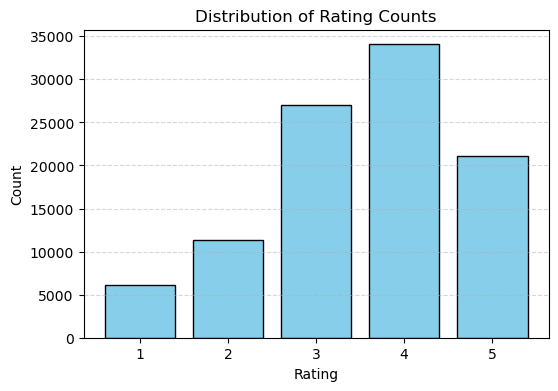

Average number of ratings $>=$ 4: {high_rating_counts.mean()}


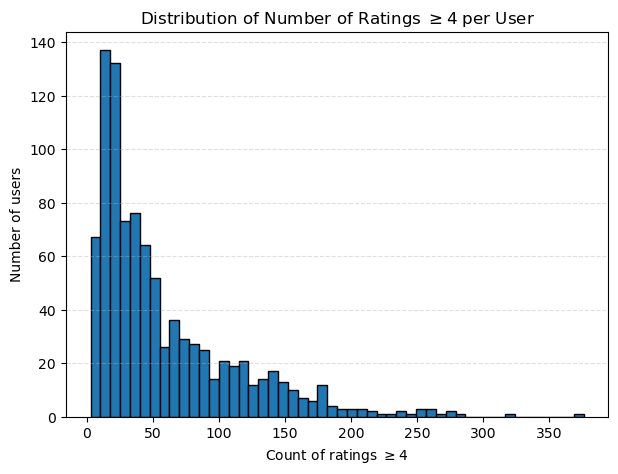

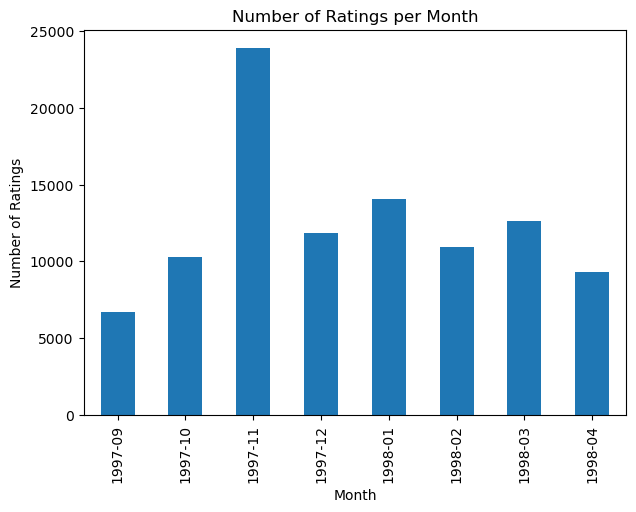

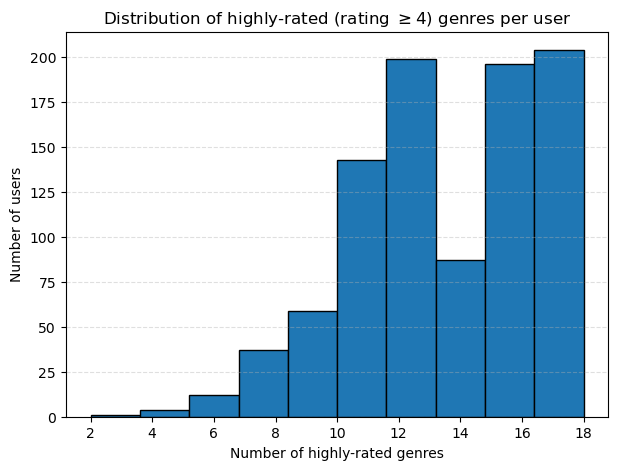

In [164]:
# Count how many times each rating occurs
rating_counts = ratings_100k_clean['rating'].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(rating_counts.index, rating_counts.values, color='skyblue', edgecolor='black')

plt.title("Distribution of Rating Counts")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(rating_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Filter ratings > 4
high_ratings = ratings_100k_clean[ratings_100k_clean['rating'] >= 4]

# Count how many such ratings per user
high_rating_counts = high_ratings.groupby('user_id')['movie_id'].count()

# Count number of unique genres that were highly-rated across all users
high_ratings = high_ratings.merge(items_100k_transformed, on="movie_id")
genre_cols = [c for c in high_ratings.columns if c not in ["user_id","movie_id","rating","timestamp","rating_timestamp","rating_month","release_date","title"]]
user_genre_counts = high_ratings.groupby("user_id")[genre_cols].max().sum(axis=1)

plt.figure(figsize=(7,5))
plt.title(r"Distribution of Number of Ratings $\geq 4$ per User")
plt.hist(high_rating_counts, bins=50, edgecolor='black')
plt.xlabel(r"Count of ratings $\geq 4$")
plt.ylabel("Number of users")
plt.grid(axis='y', linestyle='--', alpha=0.4)
print(f"Average number of ratings >= 4: {high_rating_counts.mean()}")

plt.figure(figsize=(7,5))
plt.title("Number of Ratings per Month")
ratings_100k_clean.groupby('rating_month')['rating'].count().plot(kind='bar')
plt.xlabel("Month")
plt.ylabel("Number of Ratings")

plt.figure(figsize=(7,5))
plt.title(r"Distribution of highly-rated (rating $\geq 4$) genres per user")
plt.hist(user_genre_counts, edgecolor='black')
plt.xlabel("Number of highly-rated genres")
plt.ylabel("Number of users")
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()

In [69]:
# Select 100k Data
ratings_processed = ratings_100k_clean
users_processed = users_100k_transformed
items_processed = items_100k_transformed
user_rate_map = user_rate_map_100k
item_titles = item_titles_100k

## Ratings Dataset

In [72]:
class RatingsDataset(torch.utils.data.Dataset):
    """
    A unified Dataset combining:
      - ID mapping
      - user features
      - movie features
      - relevant_ratings lookup
      - subset & subset_by_users
      - returns full tuple for two-tower or MF/NCF
    """

    def __init__(
        self,
        ratings_df: pd.DataFrame,
        users_df: pd.DataFrame,
        movies_df: pd.DataFrame,
        ratings_threshold: float = 4.0
    ):
        # --------------------------------------------
        # 1) Build ID mappings
        # --------------------------------------------
        self.ratings_df = ratings_df.reset_index(drop=True)

        self.user2idx = {u: i for i, u in enumerate(users_df["user_id"].unique())}
        self.movie2idx = {m: i for i, m in enumerate(movies_df["movie_id"].unique())}

        self.idx2user = {v: k for k, v in self.user2idx.items()}
        self.idx2movie = {v: k for k, v in self.movie2idx.items()}

        # --------------------------------------------
        # 2) Prepare user / movie metadata
        # --------------------------------------------
        self.users_df = users_df.set_index("user_id")
        self.movies_df = movies_df.set_index("movie_id")

        self.user_feature_cols = [c for c in users_df.columns if c != "user_id"]
        self.movie_feature_cols = [c for c in movies_df.columns if c not in ["movie_id", "title"]]
        self.num_item_features = len(self.movie_feature_cols)
        self.num_user_features = len(self.user_feature_cols)

        # --------------------------------------------
        # 3) Convert rating df to tensors
        # --------------------------------------------
        self.user_idxs = torch.tensor(
            self.ratings_df["user_id"].map(self.user2idx).values,
            dtype=torch.long
        )

        self.movie_idxs = torch.tensor(
            self.ratings_df["movie_id"].map(self.movie2idx).values,
            dtype=torch.long
        )

        self.ratings = torch.tensor(
            self.ratings_df["rating"].values,
            dtype=torch.float32
        )

        # --------------------------------------------
        # 4) Relevant ratings dictionary
        # --------------------------------------------
        self.relevant_ratings = defaultdict(set)
        for _, row in self.ratings_df.iterrows():
            if row["rating"] >= ratings_threshold:
                self.relevant_ratings[row["user_id"]].add(row["movie_id"])

        # --------------------------------------------
        # 5) Useful metadata
        # --------------------------------------------
        self.unique_users = users_df["user_id"].unique()
        self.unique_movies = movies_df["movie_id"].unique()
        self.num_users = len(self.unique_users)
        self.num_items = len(self.unique_movies)

    # -------------------------------------------------
    # Length
    # -------------------------------------------------
    def __len__(self):
        return len(self.ratings)

    # -------------------------------------------------
    # Item retrieval
    # -------------------------------------------------
    def __getitem__(self, idx):
        uid_idx = self.user_idxs[idx].item()
        mid_idx = self.movie_idxs[idx].item()
        rating = self.ratings[idx].item()

        # Original IDs
        uid = self.idx2user[uid_idx]
        mid = self.idx2movie[mid_idx]

        # Features
        user_features = self.users_df.loc[uid][self.user_feature_cols].values.astype(np.float32)
        movie_features = self.movies_df.loc[mid][self.movie_feature_cols].values.astype(np.float32)

        return (
            uid_idx,           # integer index
            mid_idx,           # integer index
            rating,
            torch.tensor(user_features, dtype=torch.float32),
            torch.tensor(movie_features, dtype=torch.float32)
        )

def get_users_from_subset(dataset):
    """
    Works for both:
    - Full RatingsDataset (train_set, val_set, test_set)
    - torch.utils.data.Subset, if used later
    Returns unique user_ids in the subset or dataset.
    """
    if hasattr(dataset, "indices"):   # It's a Subset
        user_idx_list = dataset.dataset.user_idxs[dataset.indices]
        idx2user = dataset.dataset.idx2user
    else:                             # It's a full Dataset
        user_idx_list = dataset.user_idxs
        idx2user = dataset.idx2user

    # Convert internal idx → original user_id
    user_ids = [idx2user[int(idx)] for idx in user_idx_list.unique()]

    return user_ids

## Data Splits & Configurations

In [75]:
# Time-based temporal splits for ML-100k
train_df = ratings_processed[
    ratings_processed['rating_month'] <= '1998-02' # 6 months of training data
].copy()

val_df = ratings_processed[
    ratings_processed['rating_month'] == '1998-03'
].copy()

test_df = ratings_processed[
    ratings_processed['rating_month'] == '1998-04'
].copy()

train_set = RatingsDataset(train_df, users_processed, items_processed)
val_set   = RatingsDataset(val_df, users_processed, items_processed)
test_set  = RatingsDataset(test_df, users_processed, items_processed)
full_dataset = RatingsDataset(ratings_processed, users_processed, items_processed)

# ----------------------------
# Data Loader Configuration
# ----------------------------
batch_size = 1024

# ----------------------------
# Training Configuration
# ----------------------------
MF_num_factors = 40
MF_loss_method = torch.nn.MSELoss(reduction='sum')
MF_learning_rate = 1e-3
MF_epochs = 30
MF_reg_weight_u = 1e-1
MF_reg_weight_i = 1e-1
MF_reg_weights = np.array([MF_reg_weight_u,MF_reg_weight_i])

# ----------------------------
# Evaluation Configuration
# ----------------------------
k = 10

In [76]:
# initialise loaders

def get_loaders(train_set, val_set, test_set, batch_size):
  train_loader = torch.utils.data.DataLoader(
      train_set,
      batch_size=batch_size,
      shuffle=True,
  )
  val_loader = torch.utils.data.DataLoader(
      val_set,
      batch_size=batch_size,
      shuffle=False
  )
  test_loader = torch.utils.data.DataLoader(
      test_set,
      batch_size=batch_size,
      shuffle=False
  )

  return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_loaders(train_set, val_set, test_set, batch_size)

# get validation and test users for precision & recall @ k
train_users = get_users_from_subset(train_set)
val_users   = get_users_from_subset(val_set)
test_users  = get_users_from_subset(test_set)
print(f"====TRAIN USERS: {len(train_users)}")
print(f"====VAL USERS: {len(val_users)}")
print(f"====TEST USERS: {len(test_users)}")

====TRAIN USERS: 736
====VAL USERS: 226
====TEST USERS: 162


# EVALUATION FUNCTIONS

In [78]:
METRICS = ["precision", "recall", "hit_rate", "ndcg"]

# ================================
# Seed Setter for multi-run evaluation
# ================================
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# ================================
# Evaluate MSE
# ================================
def evaluate_mse(model: torch.nn.Module,
                 loader: torch.utils.data.dataloader.DataLoader) -> float:
    sq_sum = 0.0
    count = 0

    model.eval()
    model.to(device)

    with torch.no_grad():
        for users, items, ratings, user_features, item_features in loader:
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)
            user_features = user_features.to(device)
            item_features = item_features.to(device)

            preds = model(users=users, items=items,
                          user_features=user_features, item_features=item_features).float()

            sq_sum += F.mse_loss(preds, ratings, reduction="sum").item()
            count += ratings.size(0)

    return sq_sum / count

# ================================
# Precision, Recall, hit rate, NDCG @ K
# ================================
def compute_metrics(k_pred_items: list,
                    relevant_items: list) -> tuple:
    k = len(k_pred_items)
    pred_set = set(k_pred_items)
    rel_set = set(relevant_items)
    hits = len(pred_set & rel_set)

    precision = hits / k if k > 0 else 0
    recall = hits / len(relevant_items) if len(relevant_items) > 0 else 0
    hit_rate = int(hits > 0)
    dcg = 0.0
    for i, item in enumerate(k_pred_items):
        if item in relevant_items:
            dcg += 1.0 / math.log2(i + 2)                           # rank is i (0-based), position = i+1
    ideal_len = min(len(relevant_items), k)
    idcg = sum(1.0 / math.log2(i + 2) for i in range(ideal_len))    # rank is i (0-based), position = i+1
    ndcg = 0.0 if idcg == 0.0 else dcg/idcg

    return precision, recall, hit_rate, ndcg

def compute_metrics_at_k(user_ids: list,
                         relevant_ratings: dict,
                         predict_fn: callable,
                         k=10) -> tuple:
    """
    - relevant_ratings: map of all unique items that are relevant to each user
    - predict_fn: takes in a user_id and k and returns the predicted top-k relevant items
    Returns average precision, recall, hit rate, and NDCG @ k over all users in user_ids.
    """
    total_p, total_r, total_hr, total_ndcg = 0.0, 0.0, 0.0, 0.0

    for uid in user_ids:
        recs = predict_fn(uid, k)
        true_rel = relevant_ratings[uid]

        p, r, hr, ndcg = compute_metrics(recs, true_rel)
        total_p += p; total_r += r; total_hr += hr; total_ndcg += ndcg

    out = (total_p, total_r, total_hr, total_ndcg)
    num_users = len(user_ids)
    return tuple(metric/num_users for metric in out)

# ================================
# Plot Metrics (subject to stylistic improvement)
# ================================
def plot_metrics_vs_epoch(train_metric: list=None, val_metric: list=None, test_metric: list=None,
                          ylabel: str='metric',
                          train_label: str='train', val_label: str='validation', test_label: str='test',
                          ax: matplotlib.axes._axes.Axes=None) -> matplotlib.axes._axes.Axes:
    if ax is None:
        f, ax = plt.subplots(); ax.set_xlabel('epoch'); ax.set_ylabel(ylabel)
    metric_set = next((x for x in [train_metric, val_metric, test_metric] if x is not None), None)
    if metric_set is None:
        return ax
    else:
        epochs = (np.arange(len(metric_set)) + 1).astype(int)
        if train_metric is not None:
            ax.plot(epochs,train_metric,label=train_label)
        if val_metric is not None:
            ax.plot(epochs,val_metric,label=val_label)
        if test_metric is not None:
            ax.plot(epochs,test_metric,label=test_label)
        ax.legend()
        return ax

def aggregate_ranking_metric(runs, metric):
    vals = [run[metric] for run in runs]
    return np.mean(vals), np.std(vals)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# MODELLING

## 1. Matrix Factorisation

In [85]:
# ================================
# Matrix Factorization Model
# ================================
class MatrixFactorisation(torch.nn.Module):
    def __init__(self,
                 dataset: RatingsDataset,
                 num_factors: int = 40,
                 use_bias: bool = True,
                 global_mean: float = None):
        super().__init__()

        self.user2idx = dataset.user2idx
        self.idx2item = dataset.idx2movie
        self.num_users = dataset.num_users
        self.num_items = dataset.num_items

        self.user_embedding = torch.nn.Embedding(self.num_users, num_factors)
        self.item_embedding = torch.nn.Embedding(self.num_items, num_factors)

        self.use_bias = use_bias
        if use_bias:
            self.user_bias = torch.nn.Embedding(self.num_users, 1)
            self.item_bias = torch.nn.Embedding(self.num_items, 1)
            torch.nn.init.constant_(self.user_bias.weight, 0.0)
            torch.nn.init.constant_(self.item_bias.weight, 0.0)
        else:
            self.user_bias = None
            self.item_bias = None

        # global mean MUST be float32
        gm = 0.0 if global_mean is None else float(global_mean)
        self.global_mean = torch.tensor(gm, dtype=torch.float32)

        torch.nn.init.xavier_uniform_(self.user_embedding.weight)
        torch.nn.init.xavier_uniform_(self.item_embedding.weight)

    def forward(self,
                users: torch.Tensor,
                items: torch.Tensor,
                *args, **kwargs) -> float:
        p = self.user_embedding(users)        # (B, F)
        q = self.item_embedding(items)        # (B, F)
        dot = (p * q).sum(dim=1)

        out = dot + self.global_mean

        if self.use_bias:
            out += self.user_bias(users).squeeze() + self.item_bias(items).squeeze()

        return out.float()

    # =========================
    # Top-K Recommendation
    # =========================
    def recommend(self,
                  user_id: int,
                  k=10,
                  user_rate_map=None) -> list:
        if user_id not in self.user2idx:
            raise ValueError(f"User ID {user_id} not found.")

        user_idx = self.user2idx[user_id]
        self.eval()

        user = torch.tensor(user_idx, dtype=torch.long, device=device)
        user_factor = self.user_embedding(user)
        item_factors = self.item_embedding.weight

        scores = item_factors @ user_factor + self.global_mean

        if self.use_bias:
            scores += self.item_bias.weight.squeeze() + self.user_bias(user).squeeze()

        scores = scores.detach().cpu().numpy()

        candidates = np.arange(len(scores))

        # filter seen
        if user_rate_map is not None and user_id in user_rate_map:
            seen = user_rate_map[user_id]
            candidates = [i for i in candidates if self.idx2item[i] not in seen]

        topk_partition_idx = np.argpartition(scores[candidates], -k)[-k:]
        topk_idx = np.array(candidates)[topk_partition_idx]
        topk_idx = topk_idx[np.argsort(scores[topk_idx])[::-1]]

        return [self.idx2item[idx] for idx in topk_idx]


# ================================
# Loss Function
# ================================
class LossFunction(object):
    def __init__(self,
                 loss_method: torch.nn.modules.loss._Loss,
                 reg_weights: np.ndarray=None):
        self.loss_method = loss_method
        self.reg_weights = reg_weights

    def __call__(self,
                 predictions: torch.Tensor,
                 targets: torch.Tensor,
                 model: torch.nn.Module=None) -> float:
        predictions = predictions.float()
        targets = targets.float()

        mse = self.loss_method(predictions, targets)

        if model is not None and self.reg_weights is not None:
            reg_loss = 0.0
            params = list(model.parameters())
            for i in range(min(len(params), len(self.reg_weights))):
                reg_loss += self.reg_weights[i] * torch.sum(params[i] ** 2)
            mse += reg_loss / len(targets)

        return mse.float()


# ================================
# Training Loop
# ================================
def train_epoch_mf(model: torch.nn.Module,
                   loader: torch.utils.data.dataloader.DataLoader,
                   loss_fn: callable,
                   optimiser: torch.optim.Optimizer) -> float:
    total_loss = 0.0
    model.train()
    model.to(device)
    for users, items, ratings, user_features, item_features in loader:
        users = users.to(device)
        items = items.to(device)
        ratings = ratings.to(device)
        user_features = user_features.to(device)
        item_features = item_features.to(device)

        predictions = model(users, items, user_features, item_features)
        loss = loss_fn(predictions, ratings, model)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    return avg_loss

# ================================
# Matrix Factorization + CBF Model
# ================================
class MatrixFactorisation_CBF(MatrixFactorisation):
    def __init__(self,
                 dataset: RatingsDataset,
                 num_factors: int=40,
                 use_bias: bool=True,
                 global_mean: float=None):
        super().__init__(dataset, num_factors, use_bias, global_mean)
        self.u_feat_proj = torch.nn.Linear(dataset.num_user_features, num_factors, bias=True)
        self.i_feat_proj = torch.nn.Linear(dataset.num_item_features, num_factors, bias=True)
        torch.nn.init.xavier_uniform_(self.u_feat_proj.weight)
        torch.nn.init.xavier_uniform_(self.i_feat_proj.weight)

    def forward(self,
                users: torch.Tensor,
                items: torch.Tensor,
                user_features: torch.Tensor,
                item_features: torch.Tensor,
                *args, **kwargs) -> torch.Tensor:
        p = self.user_embedding(users) + self.u_feat_proj(user_features)
        q = self.item_embedding(items) + self.i_feat_proj(item_features)
        
        dot = (p * q).sum(dim=1)
        out = dot + self.global_mean

        if self.use_bias:
            b_u = self.user_bias(users).squeeze()
            b_i = self.item_bias(items).squeeze()
            out += b_u + b_i
        return out

# ================================
# Matrix Factorisation e2e
# ================================
def MF_e2e(dataset: RatingsDataset,
           num_factors: int,
           learning_rate: float,
           loss_method: torch.nn.modules.loss._Loss,
           train_loader: torch.utils.data.dataloader.DataLoader,
           val_loader: torch.utils.data.dataloader.DataLoader,
           epochs: int, k: int=10,
           with_CBF: bool=False, reg_weights: list=None) -> dict:
    # Model, Optimiser, Loss Function
    if with_CBF:
        model = MatrixFactorisation_CBF(dataset, num_factors)
    else:
        model = MatrixFactorisation(dataset, num_factors)
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if reg_weights is None:
        loss_fn = LossFunction(loss_method) # no regularisation
    else:
        loss_fn = LossFunction(loss_method, reg_weights) # regularisation
    # Train & Evaluate
    train_avg_mses = []; val_mses = []
    train_ps = []; train_rs = []; train_hrs = []; train_ndcgs = []
    val_ps = []; val_rs = []; val_hrs = []; val_ndcgs = []
    train_times = []; eval_times = []
    for epoch in tqdm(range(1,epochs+1)):
        # Train
        start_train = time.perf_counter()
        train_loss = train_epoch_mf(model, train_loader, loss_fn, optimiser)
        train_times.append(time.perf_counter() - start_train)
        # Evaluate
        val_mse = evaluate_mse(model, val_loader)
        train_avg_mses.append(train_loss)
        val_mses.append(val_mse)
        train_p, train_r, train_hr, train_ndcg = compute_metrics_at_k(train_users,
                                                                      dataset.relevant_ratings,
                                                                      model.recommend,
                                                                      k)
        start_eval = time.perf_counter()
        val_p, val_r, val_hr, val_ndcg = compute_metrics_at_k(val_users,
                                                              dataset.relevant_ratings,
                                                              model.recommend,
                                                              k)
        eval_times.append(time.perf_counter() - start_eval)
        train_ps.append(train_p); train_rs.append(train_r); train_hrs.append(train_hr); train_ndcgs.append(train_ndcg)
        val_ps.append(val_p); val_rs.append(val_r); val_hrs.append(val_hr); val_ndcgs.append(val_ndcg)
    # Test
    start_test = time.perf_counter()
    test_p, test_r, test_hr, test_ndcg = compute_metrics_at_k(test_users,
                                                              dataset.relevant_ratings,
                                                              model.recommend,
                                                              k)
    test_time = time.perf_counter() - start_test
    return {
        'model': model,
        'training': {
            'mse': train_avg_mses,
            'precision': train_ps,
            'recall': train_rs,
            'hit_rate': train_hrs,
            'ndcg': train_ndcgs,
        },
        'validation': {
            'mse': val_mses,
            'precision': val_ps,
            'recall': val_rs,
            'hit_rate': val_hrs,
            'ndcg': val_ndcgs,
        },
        'testing': {
            'precision': test_p,
            'recall': test_r,
            'hit_rate': test_hr,
            'ndcg': test_ndcg,
        },
        'k': k,
        'train_times': train_times,
        'eval_times': eval_times,
        'test_time': test_time
    }

# ================================
# Matrix Factorisation Plots
# ================================
def MF_plot_results(results: dict) -> None:
    print(f"Final train average MSE={results['training']['mse'][-1]:.4f}\n"
          f"\tvalidation MSE={results['validation']['mse'][-1]:.4f}\n"
          f"\ttest precision={results['testing']['precision']:.4f} | recall={results['testing']['recall']:.4f} | hit rate={results['testing']['hit_rate']:.4f} | NDCG={results['testing']['ndcg']:.4f}\n"
          f"\ttest time={results['test_time']:.4f}")
    k = results['k']
    plot_metrics_vs_epoch(results['training']['mse'], results['validation']['mse'], ylabel='MSE')
    plot_metrics_vs_epoch(results['training']['precision'], results['validation']['precision'], ylabel=f'precision@{k}')
    plot_metrics_vs_epoch(results['training']['recall'], results['validation']['recall'], ylabel=f'recall@{k}')
    plot_metrics_vs_epoch(results['training']['hit_rate'], results['validation']['hit_rate'], ylabel=f'hit rate@{k}')
    plot_metrics_vs_epoch(results['training']['ndcg'], results['validation']['ndcg'], ylabel=f'NDCG@{k}')

In [ ]:
mf_results = []
for seed in SEEDS:
  set_seed(seed)
  results = MF_e2e(full_dataset, MF_num_factors, MF_learning_rate, MF_loss_method, train_loader, val_loader, MF_epochs)
  mf_results.append(results)
  MF_plot_results(results)

for m in METRICS:
    mean, sd = aggregate_ranking_metric([run['testing'] for run in mf_results], m)
    print(f"{m}: {mean:.4f} ± {sd:.4f}")

pickle.dump(mf_results, open("mf_results.pkl", "wb")) # save results

## 2. Matrix Factorisation + CBF

In [ ]:
mf_cbf_results = []
for seed in SEEDS:
  set_seed(seed)
  results = MF_e2e(full_dataset, MF_num_factors, MF_learning_rate, MF_loss_method, train_loader, val_loader, MF_epochs, with_CBF=True)
  mf_cbf_results.append(results)
  MF_plot_results(results)

for m in METRICS:
    mean, sd = aggregate_ranking_metric([run['testing'] for run in mf_cbf_results], m)
    print(f"{m}: {mean:.4f} ± {sd:.4f}")

pickle.dump(mf_cbf_results, open("mf_cbf_results.pkl", "wb")) # save results

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [31:09<00:00, 62.31s/it]


Final train average MSE=704.6368
	validation MSE=1.3809
	test precision=0.2395 | recall=0.0322 | hit rate=0.7531 | NDCG=0.2457
	test time=0.0489


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [30:46<00:00, 61.55s/it]


Final train average MSE=732.6279
	validation MSE=1.5243
	test precision=0.2025 | recall=0.0291 | hit rate=0.7531 | NDCG=0.2156
	test time=0.0475


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [34:20<00:00, 68.69s/it]
C:\Users\edwin\AppData\Local\Temp\ipykernel_22440\2752729970.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(); ax.set_xlabel('epoch'); ax.set_ylabel(ylabel)


Final train average MSE=697.8309
	validation MSE=1.3073
	test precision=0.1914 | recall=0.0293 | hit rate=0.7654 | NDCG=0.1983
	test time=0.0656


  3%|██▊                                                                                | 1/30 [01:14<35:56, 74.37s/it]

# 3. TwoTower Recommender

## 3.1 Towers

In [17]:
# -------------------------------
# User Tower
# -------------------------------
class UserTower(nn.Module):
    def __init__(self, num_users, user_feat_dim, embed_dim=64, dropout=0.1):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embed_dim)
        nn.init.xavier_uniform_(self.user_embedding.weight)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim + user_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, embed_dim)
        )

    def forward(self, user_idx, user_feats):
        base_emb = self.user_embedding(user_idx)
        x = torch.cat([base_emb, user_feats], dim=-1)

        # Residual connection from embedding
        out = base_emb + self.mlp(x)

        # Normalize for stable dot-product retrieval
        return F.normalize(out, p=2, dim=-1)


# -------------------------------
# Movie Tower
# -------------------------------
class MovieTower(nn.Module):
    def __init__(self, num_movies, movie_feat_dim, embed_dim=64, dropout=0.1):
        super().__init__()
        self.movie_embedding = nn.Embedding(num_movies, embed_dim)
        nn.init.xavier_uniform_(self.movie_embedding.weight)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim + movie_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, embed_dim)
        )

    def forward(self, movie_idx, movie_feats):
        base_emb = self.movie_embedding(movie_idx)
        x = torch.cat([base_emb, movie_feats], dim=-1)
        out = base_emb + self.mlp(x)
        return F.normalize(out, p=2, dim=-1)


# -------------------------------
# Two-Tower Model
# -------------------------------
class TwoTowerModel(nn.Module):
    def __init__(self, num_users, num_movies, user_feat_dim, movie_feat_dim, embed_dim=64):
        super().__init__()
        self.user_tower = UserTower(num_users, user_feat_dim, embed_dim)
        self.movie_tower = MovieTower(num_movies, movie_feat_dim, embed_dim)

    def forward(self, user_idx, movie_idx, user_feats, movie_feats):
        """
        Returns embeddings from both towers
        """
        user_vec = self.user_tower(user_idx, user_feats)    # (batch_size, embed_dim)
        movie_vec = self.movie_tower(movie_idx, movie_feats)
        return user_vec, movie_vec

## 3.2 Training Utils

In [20]:
# ----------------------------
# 5) Training helpers (retrieval)
# ----------------------------
def calculate_in_batch_recall_retrieval(scores, k=10):
    """
    Calculates in-batch Precision@K and Recall@K.
    Each user has exactly 1 positive: item at the same batch index.
    """
    batch_size = scores.shape[0]

    # Adjust k if batch is smaller
    actual_k = min(k, scores.shape[1])

    # Get top-K predicted item indices for each user
    _, topk_indices = torch.topk(scores, k=actual_k, dim=1)  # (B, K)

    # True positive index for each user: i -> i
    positive_indices = torch.arange(batch_size, device=scores.device).unsqueeze(1)  # (B, 1)

    # Check if positive is in top-K
    is_hit = (topk_indices == positive_indices)  # (B, K)

    # Recall@K: did we retrieve the true positive?
    hits = is_hit.any(dim=1).float()  # (B,)
    recall_at_k = hits.mean().item()

    return recall_at_k

def train_one_epoch_retrieval(
    model,
    loader,
    optimizer,
    device,
    top_k=100,
):
    """
    Train one epoch with in-batch negatives.
    Metrics computed *within the batch*:
      - Positive for user i is the i-th movie in the batch
      - We check whether that positive is inside the top_k among the batch candidates
    Returns: avg_loss, avg_precision, avg_recall (batch-averaged)
    """
    model.train()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_batch_rec = 0.0

    for batch in tqdm(loader, desc="Retrieval train"):
        user_idx, movie_idx, ratings, user_feats, movie_feats = batch
        user_idx = user_idx.to(device)
        movie_idx = movie_idx.to(device)
        user_feats = user_feats.to(device)
        movie_feats = movie_feats.to(device)

        # forward
        user_vec, movie_vec = model(user_idx, movie_idx, user_feats, movie_feats)
        scores = torch.matmul(user_vec, movie_vec.T)  # (B, B)
        labels = torch.arange(scores.size(0), device=device)

        loss = criterion(scores, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        total_batch_rec += calculate_in_batch_recall_retrieval(scores, top_k)

    avg_loss = total_loss / len(loader)
    avg_rec = total_batch_rec / len(loader)

    print(f"Train Loss: {avg_loss:.4f} | In-batch R@{top_k}: {avg_rec:.4f}")
    return avg_loss, avg_rec


def evaluate_retrieval(model, loader, device, top_k=100):
    """
    Evaluation that matches train_one_epoch_retrieval EXACTLY.
    Uses only in-batch negatives and calculate_in_batch_retrieval_metrics().
    """

    model.eval()
    criterion = nn.CrossEntropyLoss()

    total_loss = 0.0
    total_rec = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Retrieval eval"):
            user_idx, movie_idx, ratings, user_feats, movie_feats = batch

            user_idx = user_idx.to(device)
            movie_idx = movie_idx.to(device)
            user_feats = user_feats.to(device)
            movie_feats = movie_feats.to(device)

            # Forward
            user_vec, movie_vec = model(user_idx, movie_idx, user_feats, movie_feats)
            scores = torch.matmul(user_vec, movie_vec.T)
            labels = torch.arange(scores.size(0), device=device)

            # Loss
            loss = criterion(scores, labels)
            total_loss += loss.item()

            # In-batch metrics (same as train)
            total_rec += calculate_in_batch_recall_retrieval(scores, top_k)

    # Averages
    avg_loss = total_loss / len(loader)
    avg_rec  = total_rec / len(loader)

    print(f"Eval Loss: {avg_loss:.4f} | "
          f"In-batch R@{top_k}: {avg_rec:.4f}")

    return avg_loss, avg_rec

# ----------------------------
# 8) Get top-K candidates
# ----------------------------
def get_top_k_candidates(retrieval_model, dataset, device, top_k=50, batch_size=512, user_idx_list=None):
    retrieval_model.eval()

    # Precompute all movie vectors
    all_movie_ids = torch.tensor(list(range(len(dataset.movie2idx))), dtype=torch.long, device=device)
    all_movie_feats = torch.tensor(
        np.vstack([dataset.movies_df.loc[dataset.idx2movie[i]][dataset.movie_feature_cols].values.astype(np.float32)
                   for i in range(len(dataset.idx2movie))]),
        dtype=torch.float32,
        device=device
    )
    with torch.no_grad():
        movie_vecs = retrieval_model.movie_tower(all_movie_ids, all_movie_feats)
    if user_idx_list is None:
        user_idx_list = list(range(len(dataset.idx2user)))

    user_candidates = {}
    user_feat_cols = dataset.user_feature_cols

    for start in range(0, len(user_idx_list), batch_size):
        batch_user_idxs = user_idx_list[start:start + batch_size]
        user_ids_for_batch = [dataset.idx2user[ui] for ui in batch_user_idxs]

        user_idxs_tensor = torch.tensor(batch_user_idxs, dtype=torch.long, device=device)
        user_feats_np = np.vstack([dataset.users_df.loc[uid][user_feat_cols].values.astype(np.float32)
                                   for uid in user_ids_for_batch])
        user_feats_t = torch.tensor(user_feats_np, dtype=torch.float32, device=device)

        with torch.no_grad():
            user_vecs = retrieval_model.user_tower(user_idxs_tensor, user_feats_t)

            scores = torch.matmul(user_vecs, movie_vecs.T)
            _, topk_indices = torch.topk(scores, k=min(top_k, scores.shape[1]), dim=1)

            for i_local, uidx in enumerate(batch_user_idxs):
                user_candidates[uidx] = topk_indices[i_local].cpu().tolist()

    return user_candidates

## 3.3 Retrieval

In [23]:

def run_retrieval_pipeline(
    dataset,
    train_loader,
    val_loader,
    test_loader,
    retrieval_epochs=2,
    embed_dim=64,
    retrieval_topk=100,
    ranker_epochs=5,
    ranker_model=None,
    device=None
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    user_feat_dim = len(dataset.user_feature_cols)
    movie_feat_dim = len(dataset.movie_feature_cols)

    retrieval_model = TwoTowerModel(
        len(dataset.user2idx),
        len(dataset.movie2idx),
        user_feat_dim,
        movie_feat_dim,
        embed_dim
    ).to(device)

    optimizer = torch.optim.Adam(retrieval_model.parameters(), lr=1e-3)

    # ----- METRICS STORAGE -----
    history = {
        "train_loss": [],
        "train_recall": [],
        "val_loss": [],
        "val_recall": [],
        "epoch_time": []
    }

    print("\n========== RETRIEVAL STAGE ==========")
    for epoch in range(retrieval_epochs):

        print(f"======== Epoch {epoch + 1}")

        # ---------------- TIMING ----------------
        start_time = time.time()

        # ---------------- TRAIN ----------------
        print("====== Training")
        train_loss, train_recall = train_one_epoch_retrieval(
            retrieval_model,
            train_loader,
            optimizer,
            device,
            top_k=retrieval_topk,
        )

        # ---------------- VALIDATION ----------------
        print("====== Validation")
        val_loss, val_recall = evaluate_retrieval(
            retrieval_model,
            val_loader,
            device,
            top_k=retrieval_topk,
        )

        elapsed = time.time() - start_time

        # store metrics
        history["train_loss"].append(train_loss)
        history["train_recall"].append(train_recall)
        history["val_loss"].append(val_loss)
        history["val_recall"].append(val_recall)
        history["epoch_time"].append(elapsed)

    # freeze model
    for p in retrieval_model.parameters():
        p.requires_grad = False

    print("\n============ RETRIEVING TOP-100 CANDIDATES ===========")
    test_candidates = get_top_k_candidates(
        retrieval_model,
        dataset,
        device,
        top_k=retrieval_topk
    )

    return {
        'retrieval_model': retrieval_model,
        'test_candidates': test_candidates,
        'history': history
    }

## 3.4 Ranking

In [26]:
def run_ranking_pipeline(
    dataset,
    train_loader,
    test_candidates,
    ranker_epochs=5,
    ranker_model=None,
    device=None
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    print("\n========== RANKER STAGE ==========")

    if ranker_model is None:
        print("No MF ranker provided. Training new MF...")
        ranker = MatrixFactorisation(dataset).to(device)
        loss_fn = LossFunction(nn.MSELoss())
        optimizer = torch.optim.Adam(ranker.parameters(), lr=1e-3)

        for epoch in range(ranker_epochs):
            print(f"========Epoch {epoch + 1}")
            train_epoch_mf(
                ranker,
                train_loader,
                loss_fn,
                optimizer,
            )
    else:
        print("Using provided MF ranker (not training).")
        ranker = ranker_model.to(device)
        ranker.eval()

    # -------------------------------
    # 4) MF Rescoring + Metric Computation
    # -------------------------------
    print("\nScoring Two-Tower candidates using MF Ranker...")

    test_users = list(test_candidates.keys())

    all_precisions = []
    all_recalls    = []
    all_hits       = []
    all_ndcgs      = []

    for uidx in test_users:

      # ---- A) Retrieved internal movie indices
      retrieved_items = test_candidates[uidx]   # already internal indices
      if len(retrieved_items) == 0:
          continue

      item_idxs = torch.tensor(
          retrieved_items,
          dtype=torch.long,
          device=device
      )

      # ---- B) User index already internal
      user_batch = torch.tensor(
          [uidx] * len(item_idxs),
          dtype=torch.long,
          device=device
      )

      # ---- C) MF scores
      with torch.no_grad():
          scores = ranker(user_batch, item_idxs).cpu().numpy()

      # ---- D) Sort by MF ranking
      sorted_indices = scores.argsort()[::-1]
      rescored_top10 = [retrieved_items[i] for i in sorted_indices[:10]]
      # rescored_top10 is a LIST — correct for compute_metrics

      # ---- E) Ground-truth relevant items (convert to internal)
      original_uid = dataset.idx2user[uidx]
      true_rel_original = dataset.relevant_ratings[original_uid]

      # Convert to list of internal indices
      true_rel_internal = [
          dataset.movie2idx[m] for m in true_rel_original
          if m in dataset.movie2idx
      ]

      # ---- F) Compute metrics
      p, r, hr, ndcg = compute_metrics(
          rescored_top10,
          true_rel_internal  # LIST, not set
      )

      all_precisions.append(p)
      all_recalls.append(r)
      all_hits.append(hr)
      all_ndcgs.append(ndcg)


    # -------------------------------
    # 5) Aggregate metrics
    # -------------------------------
    precision = sum(all_precisions) / len(all_precisions)
    recall    = sum(all_recalls)    / len(all_recalls)
    hit_rate  = sum(all_hits)       / len(all_hits)
    ndcg      = sum(all_ndcgs)      / len(all_ndcgs)

    print(f"MF-rescored Precision@10: {precision:.4f}")
    print(f"MF-rescored Recall@10:    {recall:.4f}")
    print(f"MF-rescored HitRate@10:   {hit_rate:.4f}")
    print(f"MF-rescored NDCG@10:      {ndcg:.4f}")

    return {
        'precision': precision,
        'recall': recall,
        'hit_rate': hit_rate,
        'ndcg': ndcg
    }

In [ ]:
# Select MF Model
MF_models = []
if 'mf_results' in locals():
    MF_models = [result['model'] for result in mf_results]
# if 'mf_cbf_results' in locals():
#     MF_models = [result['model'] for result in mf_cbf_results]

In [ ]:
embed_dim = 32  # originally 64
retrieval_epochs = 5
ranker_epochs = 5
retrieval_size = 100    # n
rank_size = 10          # k

train_loader, val_loader, test_loader = get_loaders(
    train_set,
    val_set,
    test_set,
    512
)

def run_full_pipeline(
    seed,
    train_set, val_set, test_set,
    retrieval_epochs,
    ranker_epochs,
    embed_dim,
    retrieval_size,
    ranker,
    device
):
    set_seed(seed)

    train_loader, val_loader, test_loader = get_loaders(
        train_set, val_set, test_set, batch_size=512
    )

    retrieval_results = run_retrieval_pipeline(
        dataset=full_dataset,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        retrieval_epochs=retrieval_epochs,
        embed_dim=embed_dim,
        retrieval_topk=retrieval_size,
        ranker_epochs=ranker_epochs,
        device=device
    )

    ranking_results = run_ranking_pipeline(
        dataset=full_dataset,
        train_loader=train_loader,
        test_candidates=retrieval_results["test_candidates"],
        ranker_epochs=ranker_epochs,
        ranker_model=ranker,
        device=device,
    )

    return {
        "retrieval": retrieval_results,
        "ranking": ranking_results
    }

e2e_runs = []

for i, seed in enumerate(SEEDS):
    print(f"Running seed {seed}...")

    MF_model = None
    if len(MF_models) > i:
        MF_model = MF_models[i]
    results = run_full_pipeline(
        seed=seed,
        train_set=train_set,
        val_set=val_set,
        test_set=test_set,
        retrieval_epochs=retrieval_epochs,
        ranker_epochs=ranker_epochs,
        embed_dim=embed_dim,
        retrieval_size=retrieval_size,
        ranker=MF_model,
        device=device,
    )
    e2e_runs.append(results)

for m in METRICS:
    mean, sd = aggregate_ranking_metric([run['ranking'] for run in e2e_runs], m)
    print(f"{m}: {mean:.4f} ± {sd:.4f}")

pickle.dump(e2e_runs, open("tt_results.pkl", "wb")) # save results

# Results

In [42]:
MF_Results = pickle.load(open("mf_results.pkl", "rb"))
MF_CBF_Results = pickle.load(open("mf_cbf_results.pkl", "rb"))
TT_Results = pickle.load(open("tt_results.pkl", "rb"))

all_results = {'MF': MF_Results, 'MF+CBF': MF_CBF_Results, 'TT': TT_Results}

In [48]:
for model, results in all_results.items():
    for m in METRICS:
        result_key = 'testing' if model.startswith('MF') else 'ranking'
        mean, sd = aggregate_ranking_metric([run[result_key] for run in results], m)
        print(f"{model}\t{m}: {mean:.4f} ± {sd:.4f}")

MF	precision: 0.2895 ± 0.0271
MF	recall: 0.0523 ± 0.0053
MF	hit_rate: 0.8477 ± 0.0254
MF	ndcg: 0.3081 ± 0.0357
MF+CBF	precision: 0.2073 ± 0.0186
MF+CBF	recall: 0.0296 ± 0.0022
MF+CBF	hit_rate: 0.7562 ± 0.0222
MF+CBF	ndcg: 0.2206 ± 0.0211
TT	precision: 0.3444 ± 0.0110
TT	recall: 0.0908 ± 0.0037
TT	hit_rate: 0.8395 ± 0.0069
TT	ndcg: 0.3605 ± 0.0139


In [87]:
full_dataset.num_user_features

4

In [89]:
users_100k

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209
